<h1> Articulated Chain Project </h1>

OPT202 first project. Code written by Andrea Simonetto, dated: 31/01/2023

<strong> Setting up </strong>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
!pip install cvxpy --user
import cvxpy as cp

def cost(x):
    N = int(len(x)/2)
    e = np.zeros(2*N)
    e[N:2*N] = np.ones(N)
    return np.dot(e, x)

def residual(x, L, a, b):
    N = int(len(x) / 2)
    # r for me is c(z), r for residual
    r = np.zeros(N+1)
    r[0] = (x[0] - 0.) ** 2 + (x[N] - 0.) ** 2 - L ** 2
    for i in range(1,N):
        r[i] = (x[i] - x[i-1])**2 + (x[N+i]-x[N+i - 1])**2 - L**2
    r[N] = (a - x[N-1]) ** 2 + (b-x[2*N-1]) ** 2 - L ** 2
    return r

Some more routines to plot the chain for later.. 

In [52]:
def plot_chain(x, a, b, legend = []):
    N = int(len(x) / 2)
    xc = np.zeros(N+2)
    yc = np.zeros(N+2)
    xc[1:N+1] = x[0:N]
    xc[N+1] = a
    yc[1:N + 1] = x[N:2*N]
    yc[N + 1] = b

    plt.plot(xc,yc, 'ko-')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(legend)
    #plt.show()

<strong>Gradient</strong>

In [4]:
def nabla_res(x, L, a, b):

    N = int(len(x) / 2)
    C = np.zeros([2*N, N+1])
    for i in range(1,N):
        C[i,i] = 2*(x[i]-x[i-1])
        C[i+N,i] = 2*(x[i+N]-x[i-1+N])
        if i<N-1:
            C[i,i+1] = -2*(x[i+1]-x[i])
            C[i+N,i+1] = -2*(x[i+1+N]-x[i+N])

    C[0,0] = 2*(x[0]-0.)
    C[N,0] = 2*(x[N]-0.)
    C[0, 1] = 2 * (x[0] - x[1])
    C[N, 1] = 2 * (x[N] - x[N+1])
    C[N-1,N] = -2*(a-x[N-1])
    C[2*N-1,N] = -2*(b-x[2*N-1])

    return np.mat(C)

def check_der(x, L, a, b):

    dx = 0.01*np.random.random(2*N)
    C = nabla_res(x, L, a, b)
    der = (residual(x+dx, L, a, b) - residual(x, L, a, b)) - np.dot(nabla_res(x, L, a, b).transpose(), dx)
    print('NORM ERROR: ', np.linalg.norm(der)/np.linalg.norm(dx))

    return

# Try and check:
N = 5
a,b = 1,-0.1
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
L = 0.25
check_der(x,L,a,b)

NORM ERROR:  0.008612476620392285


<h3> Newton's Method Elements</h3>

In [5]:
def nabla_F(x, lbd):
    """
    nabla_F computes the upper left block of the Newton's method Hessian
    """
    N = int(len(x) / 2)
    nF = np.zeros([2*N, 2*N])
    for i in range(N):
        if i>0:
            nF[i,i-1] = -2*lbd[i]
            nF[N + i, N + i - 1] = -2 * lbd[i]

        nF[i, i] = 2 * (lbd[i]+lbd[i+1])
        nF[N + i, N + i] = 2 * (lbd[i] + lbd[i + 1])


        if i<N-1:
            nF[i, i+1] = -2 * lbd[i+1]
            nF[N+i, N+i + 1] = -2 * lbd[i + 1]

    return nF

def check_nF(x, lbd, L, a, b):
    N = int(len(x) / 2)
    dx = np.random.random(2*N)

    df1 = np.dot(nabla_res(x+dx, L, a, b), lbd) - np.dot(nabla_res(x, L, a, b), lbd)
    df2 = np.dot(nabla_F(x, lbd),dx)

    print('NORM ERROR : ', np.linalg.norm(df1 - df2)/np.linalg.norm(dx))

    return

# marking sure Nabla F is correct
lmbda = 0.1*np.random.random(N+1)
check_nF(x, lmbda, L, a, b)

NORM ERROR :  2.0044479928814815e-17


In [6]:
def newton_iteration_elements(x, lbd, L, a, b):
    N = int(len(x) / 2)
    # build system
    
    A11 = nabla_F(x, lbd)
    A12 = nabla_res(x, L, a, b)
    A21 = A12.transpose()
    A22 = np.zeros([N+1, N+1])
    A1r = np.concatenate((A11, A12),axis=1)
    A2r = np.concatenate((A21, A22),axis=1)
    A = np.concatenate((A1r, A2r), axis=0)
    #
    e = np.zeros(2 * N)
    e[N:2 * N] = np.ones(N)
    rhs1 = e + np.dot(A12, lbd)
    rhs2 = residual(x, L, a, b)
    rhs = np.zeros([3*N+1])
    rhs[:2*N] = rhs1
    rhs[2*N:] = rhs2
    
    return A, rhs

<strong> Newton's iteration and solution </strong>

In [60]:
def newton_iteration(x, lbd, L, a, b, backtracking = True):
    N = int(len(x) / 2)
    # build system
    A, rhs = newton_iteration_elements(x, lbd, L, a, b)

    # solve system
    """
    Here you can code your contribution to do one step of the Newton's method
    """
    
    alpha=1  #coeff de backtracking
    d = alpha*(- np.linalg.inv(A)*rhs.reshape(-1,1))
    d=d.reshape(1,-1)
    
    d=np.array(d)
    d=d[0]
    x=x+d[:2*N]
    lbd=lbd +d[2*N:]
   
    gap = np.linalg.norm(rhs)
    

    return x, lbd, gap

def solve_chain(x0, lbd0, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True):

    """
    this solves the chain with your Newton method. This controls the number of iterations and 
    the stopping criterion
    """
    err,n = 1,0
    x = x0
    lbd = lbd0
    g = list()
    while (n<Nmax) and (err>tol):
        n+=1
        
        x, lbd, gap = newton_iteration(x, lbd, L, a, b, backtracking = backtracking)
        
        g.append(gap)
        err = gap

    return x, lbd, g

def check_stationarity(x, lbd, gap):

    if gap[-1]<1e-3:
        F = nabla_F(x, lbd)
        e, dummy = np.linalg.eigh(F)
        print('Eigenvalues : ', np.min(e), np.max(e))
        if np.min(e)>0:
            print('A local optimizer found')
    return

def plot_convergence(opt_gap): 
    
    plt.loglog(opt_gap, 'o-')
    plt.grid()
    plt.xlabel('Iteration count')
    plt.ylabel('Optimality gap (norm residual)')
    plt.show()

In [24]:
def solve_chain_cvxpy(L, a, b, N):
    # Déclaration des variables
    u = cp.Variable((N+2,2))

    # Définition de la fonction objectif
    fonction_obj = cp.sum(u[:,1])

    # Calcul de X et Q
    X = cp.Variable((N+2,N+2))
    Q = cp.bmat([[np.identity(2), u.T], [u, X]]).T

    # Définition des contraintes
    constraints = [X[i,i] - 2*X[i,i+1] + X[i+1,i+1] - L**2 == 0 for i in range(N+1)]
    constraints += [X[0,0] == 0, X[N+1,N+1] == a**2 + b**2]
    constraints += [X==X.T,
                    cp.lambda_min(X) >= 0]
    constraints += [u[0,:] == [0,0], u[N+1,:] == [a,b]]
    constraints += [cp.lambda_min(Q) >= 0]
    
    
    # Définition du problème d'optimisation
    probleme = cp.Problem(cp.Minimize(fonction_obj), constraints)

    # Résolution du problème d'optimisation
    probleme.solve()

    return u




<strong> Examples </strong>

var15345
Eigenvalues :  2.479404757053923 27.105799049938703
A local optimizer found


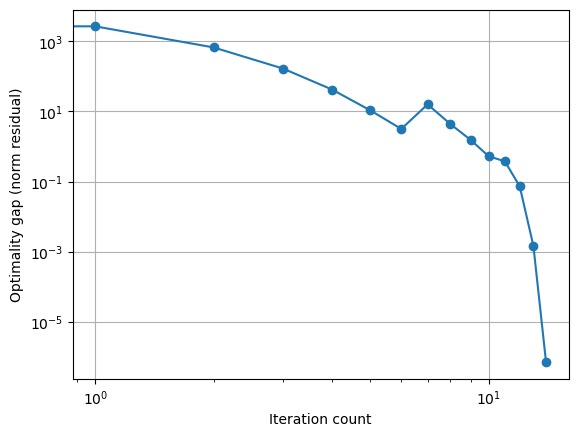

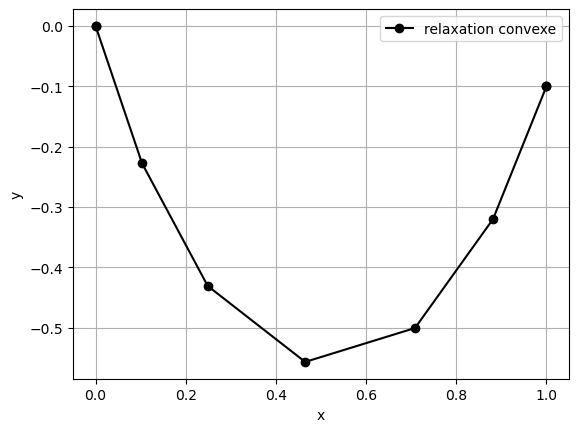

In [71]:
N = 5
L = 0.25
a,b = 1.,-.1

#sans backtracking
x = np.zeros(2*N)
x[0:N] = np.linspace(1./(N+1), a-1./(N+1), N)
x[N:2*N] =[b*i -.1*(i-a/2.)**2 for i in x[0:N]]
lmbda = 0.1*np.random.random(N+1)
x_sol, lmbda_sol, opt_gap = solve_chain(x, lmbda, L, a, b, Nmax = 100, tol = 1e-6, backtracking = True)

#avec backtracking


#relaxation convexe
u = solve_chain_cvxpy(L, a, b, N)
u=u.value

x_sol_cvxpy=[]
for i in range(N+2):
    x_sol_cvxpy.append(u[i,0])
for i in range(N+2):
    x_sol_cvxpy.append(u[i,1])

    
check_stationarity(x_sol, lmbda_sol, opt_gap)
plot_convergence(opt_gap)

#plot_chain(x_sol, a, b,legend=['sans backtracking'])
#plot_chain(x_sol, a, b,legend=['avec backtracking'])
plot_chain(x_sol_cvxpy, a, b,legend=['relaxation convexe'])

